In [1]:
!pip3 install yfinance --upgrade --no-cache-dir
import yfinance as yf
import numpy as np
import pandas as pd
import math
import re
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import datetime


In [2]:
# Get Golds daily closing price from yahoo finance
# Trim down to monthly to have fewer datapoints. Use last day closing price for each month as value.

gold = yf.Ticker("GC=F")
gold_history = gold.history(period="20y")

df = pd.DataFrame(data=gold_history)
df = df.filter(items=['Close'])
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d').strftime('%Y-%m')
df = df.groupby([df.index]).last()
df.head(5)

,Close
Date,
2002-06,313.500000
2002-07,303.200012
2002-08,312.399994
2002-09,323.899994
2002-10,318.000000


In [3]:
# Rename columns and add index for easier iteration later

df.rename(columns = {'Close':'Price'}, inplace = True)
df.reset_index(inplace=True)
close = df.copy()
df.head(5)

,Date,Price
0,2002-06,313.500000
1,2002-07,303.200012
2,2002-08,312.399994
3,2002-09,323.899994
4,2002-10,318.000000


In [4]:
#create mean,min and max for each month until most recent. Ignore datapoints where not enough historical data exists.
rolling_window_months = 3

for index,row in df.iterrows():
    if index-3 > 0 :
        df.loc[df.index[index], 'mean_3m'] = df['Price'][(index-rolling_window_months):index].mean()
    else:
        df.loc[df.index[index], 'mean_3m'] = np.nan

for index,row in df.iterrows():
    if index-3 > 0:
        df.loc[df.index[index], 'min_3m'] = df['Price'][(index-rolling_window_months):index].min()
    else:
        df.loc[df.index[index], 'min_3m'] = np.nan
        
for index,row in df.iterrows():
    if index-3 > 0:
        df.loc[df.index[index], 'max_3m'] = df['Price'][(index-rolling_window_months):index].max()
    else:
        df.loc[df.index[index], 'max_3m'] = np.nan

In [5]:
df.tail(5)

,Date,Price,mean_3m,min_3m,max_3m
236,2022-02,1899.400024,1798.699992,1773.599976,1827.500000
237,2022-03,1949.199951,1840.633341,1795.000000,1899.400024
238,2022-04,1909.300049,1881.199992,1795.000000,1949.199951
239,2022-05,1842.699951,1919.300008,1899.400024,1949.199951
240,2022-06,1826.500000,1900.399984,1842.699951,1949.199951


<AxesSubplot:xlabel='Date'>

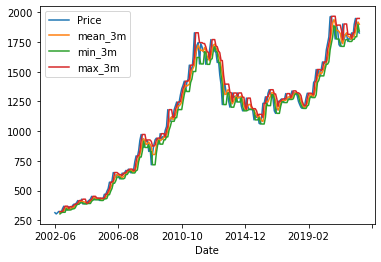

In [6]:
# sneapeak of our new values
df.plot(x='Date')

In [7]:
# If at a certain month, the price closes highest in the last 3 months
# AND the distance to mean is 75% (adjustable) higher than distance of previous max to mean: upward alert

# If at a certain date, the price closes lowest in the last 30days
# AND the distance to mean is 75% (adjustable) lower than distance of previous min to mean: downward alert



for index,row in df.iterrows():
    if df.loc[df.index[index], 'Price'] > df.loc[df.index[index], 'max_3m']\
        and math.dist([df.loc[df.index[index], 'Price']], [df.loc[df.index[index], 'mean_3m']]) >\
            math.dist([df.loc[df.index[index], 'max_3m']], [df.loc[df.index[index], 'mean_3m']])*1.75:
                df.loc[df.index[index], 'Alert'] = "Price jump alert"
    elif df.loc[df.index[index], 'Price'] < df.loc[df.index[index], 'min_3m']\
        and math.dist([df.loc[df.index[index], 'mean_3m']], [df.loc[df.index[index], 'Price']]) >\
            math.dist([df.loc[df.index[index], 'mean_3m']], [df.loc[df.index[index], 'min_3m']])*1.75:
                df.loc[df.index[index], 'Alert'] = "Price drop alert"
    else:
        pass

In [8]:
# This is the final output sheet with detected anomalies, but will split them between up and down.

df1 = df[df['Alert'].notnull()]
df.count()

Date       241
Price      241
mean_3m    237
min_3m     237
max_3m     237
Alert       90
dtype: int64

In [9]:
up_df = df1[df1['Alert'] == 'Price jump alert']
down_df = df1[df1['Alert'] == 'Price drop alert']

In [10]:
# change Dates back to indexes in order to get dates/years in X axis when plotting
df = df.set_index('Date')
up_df = up_df.set_index('Date')
down_df = down_df.set_index('Date')

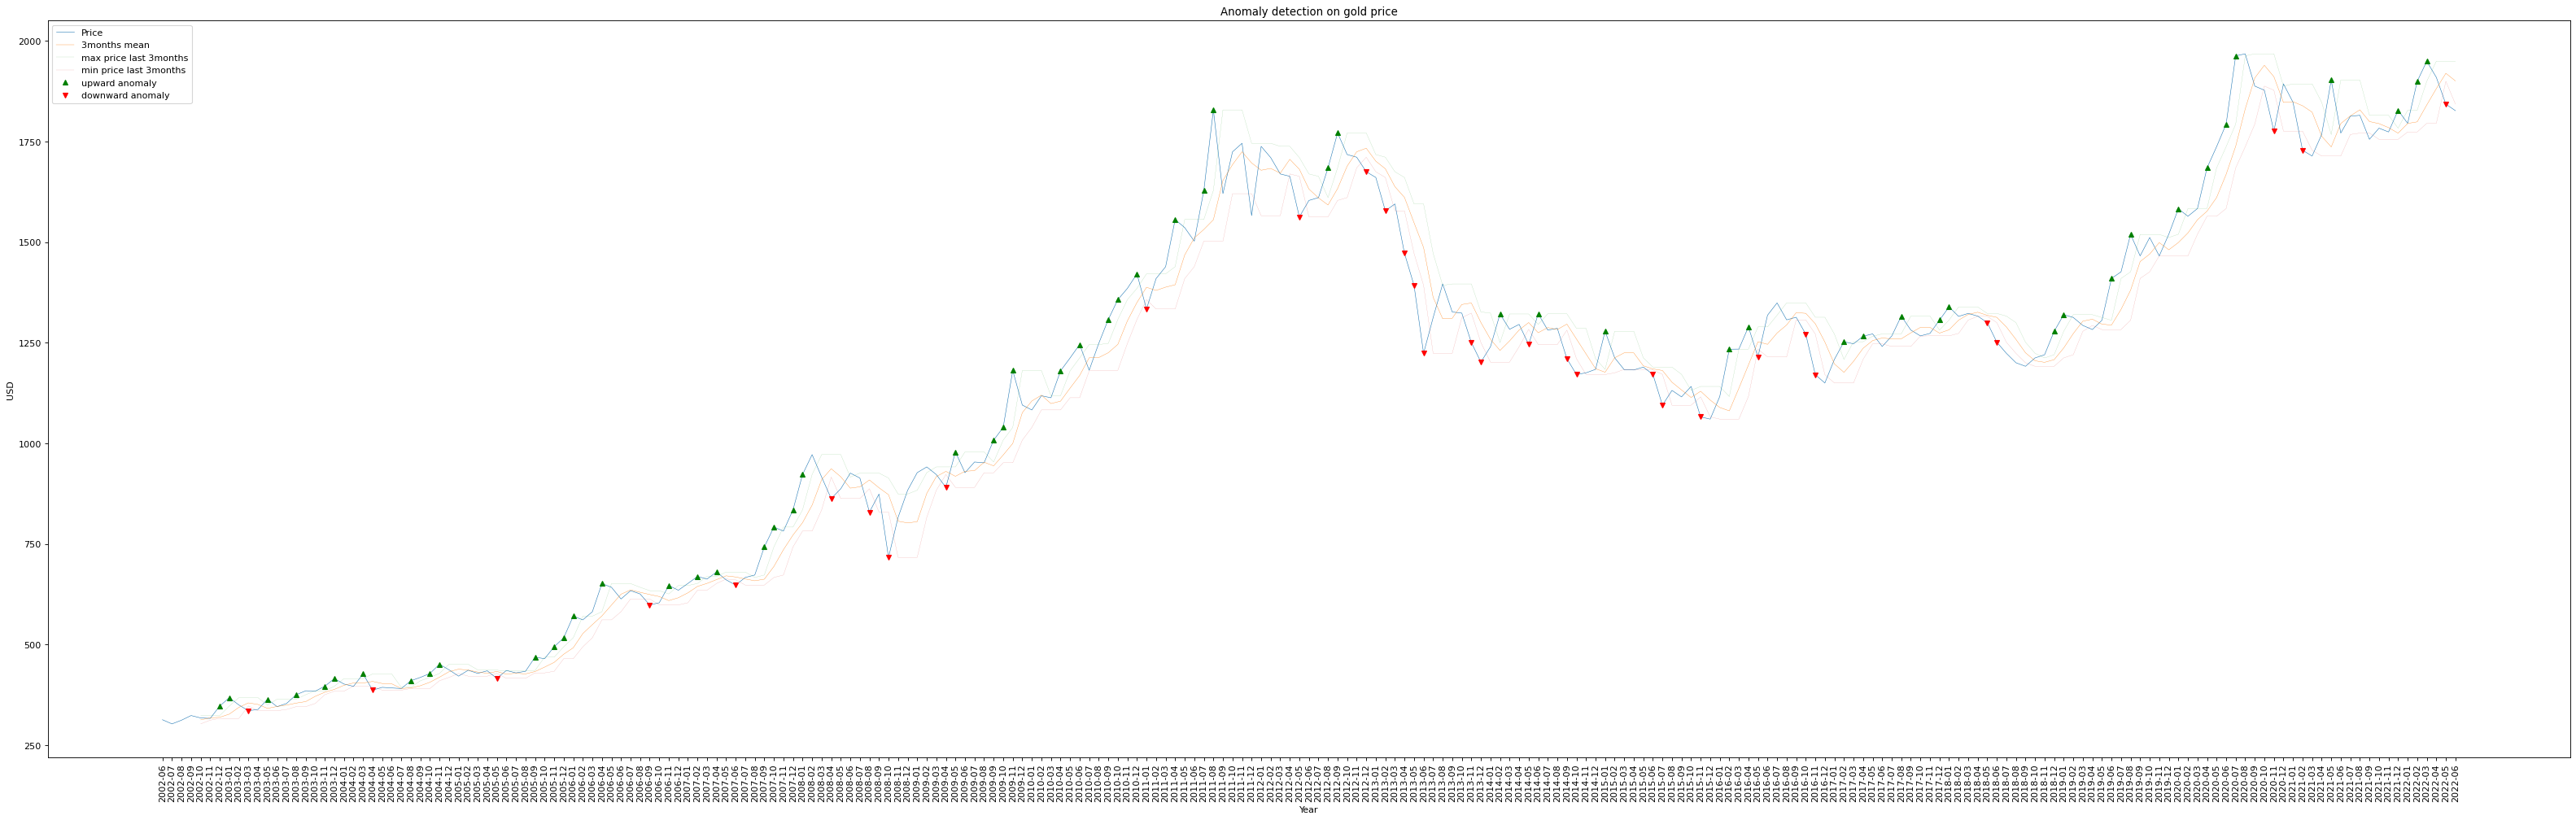

In [15]:
figure(figsize=(50, 15), dpi=80)

plt.plot(df['Price'],label='Price',linewidth=0.5,)
plt.plot(df['mean_3m'],label='3months mean',linewidth=0.3)
plt.plot(df['max_3m'],label='max price last 3months',linewidth=0.1)
plt.plot(df['min_3m'],label='min price last 3months',linewidth=0.1)

plt.plot(up_df['Price'],'g^',label='upward anomaly')
plt.plot(down_df['Price'], 'rv',label='downward anomaly')

plt.title('Anomaly detection on gold price')
plt.xlabel('Year')
plt.ylabel('USD')
plt.xticks(rotation=90)
plt.legend()

plt.show()